История о локальных свойствах городских объектов и базовой инфраструктуре района

In [1]:
import osmnx as ox
import geopandas as gpd
import pandas as pd

Допустим у нас есть картографические данные всех строений районов, а также данные о размещении торговых объектов. Можно попробовать их упорядочить в пространственный индекс, а затем для каждого строения взять некоторую окрестность и проверить, сколько заведений туда попадает.  

In [2]:
place_name = 'Тверской район, Москва, Россия'
district = ox.geometries.geometries_from_place(place_name, tags = {'building': True})

In [3]:
df = pd.read_json(r'datasets/data-28509-2021-07-11.json', encoding='cp1251')
df10 = df[0:10]
df100 = df[0:100]

In [4]:
from shapely.geometry import Point

coords = [Point(row['Longitude_WGS84'], row['Latitude_WGS84']) for index, row in df.iterrows()]
shops = gpd.GeoDataFrame(df, geometry=coords, crs='EPSG:4326')
shops_t = shops[shops['District'] == 'Тверской район']
shops_t.head(3)

,Latitude_WGS84,Longitude_WGS84,global_id,UNOM,ID,Name,IsNetObject,OperatingCompany,TypeService,TypeObject,AdmArea,District,Address,PublicPhone,WorkingHours,ClarificationOfWorkingHours,geoData,geodata_center,geometry
1,55.786559,37.594849,637391109,16938,69320,АЙКОВЕР,нет,,реализация непродовольственных товаров,Магазин-салон,Центральный административный округ,Тверской район,"город Москва, Новослободская улица, дом 50/1, ...",[{'PublicPhone': '(499) 250-12-40'}],"[{'DayOfWeek': 'понедельник', 'Hours': '10:00-...",,"{'coordinates': [37.5948494823958, 55.78655886...","{'type': 'geometry', 'value': '010100000055772...",POINT (37.59485 55.78656)
38,55.785636,37.595859,637401009,16909,125278,Цветочная 24 база,нет,,реализация непродовольственных товаров,Магазин «Цветы»,Центральный административный округ,Тверской район,"город Москва, Новослободская улица, дом 46",[{'PublicPhone': '(925) 155-62-27'}],"[{'DayOfWeek': 'понедельник', 'Hours': 'кругло...",,"{'coordinates': [37.5958593893983, 55.78563612...","{'type': 'geometry', 'value': '01010000007B3DD...",POINT (37.59586 55.78564)
140,55.767890,37.618975,637431959,430205,125849,BRANDSHOP,нет,,реализация непродовольственных товаров,Магазин «Обувь»,Центральный административный округ,Тверской район,"город Москва, Петровский бульвар, дом 21",[{'PublicPhone': '(495) 544-57-70'}],"[{'DayOfWeek': 'понедельник', 'Hours': '10:00-...",,"{'coordinates': [37.6189749341622, 55.76788970...","{'type': 'geometry', 'value': '010100000099A21...",POINT (37.61897 55.76789)


In [5]:
from shapely.geometry import box

# spatial index for shops dataset
shops_t_sindex = shops_t.sindex
type(shops_t_sindex)

geopandas.sindex.RTreeIndex

In [6]:
from pyproj import Geod
from shapely.geometry import box

# box-neighbourhood generation routine 
def distance_box(lon, lat, distance): # distance in meters
    g = Geod(ellps='clrk66') # geodesic calculation object
    
    #given latitude (lat), longitude (lon) values for the location
    top_right_corner = g.fwd(lon, lat, 45, distance)
    bottom_right_corner = g.fwd(lon, lat, 135, distance)
    bottom_left_corner = g.fwd(lon, lat, 225, distance)
    top_left_corner = g.fwd(lon, lat, 315, distance)
    
    max_lon = top_right_corner[0]
    max_lat = bottom_right_corner[1]
    min_lon = bottom_left_corner[0]
    min_lat = top_left_corner[1]
    
    return box(max_lon, max_lat, min_lon, min_lat)

In [7]:
box_query = distance_box(37.59, 55.77, 500)
index = shops_t_sindex.query(box_query)
located_shops = shops_t.iloc[index]

На рисунке представлены для сравнения результаты локального поиска и отображения полного набора данных

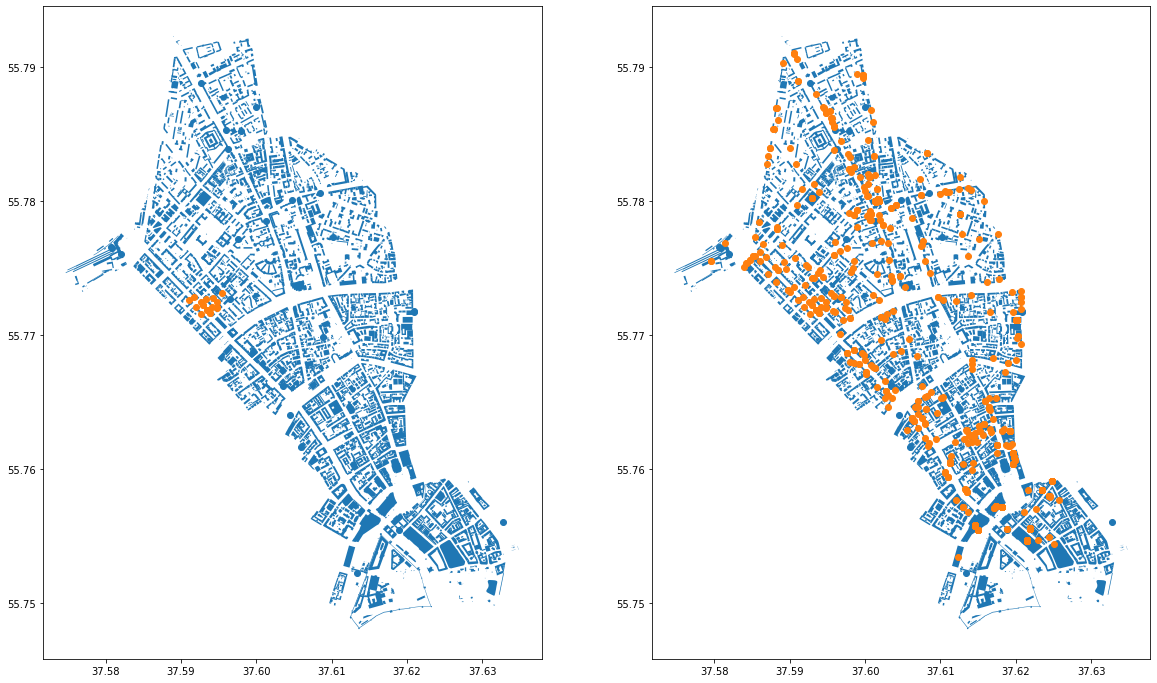

In [21]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(20, 12))

axes[0] = district.plot(ax=axes[0])
located_shops.plot(ax=axes[0])

axes[1] = district.plot(ax=axes[1])
shops_t.plot(ax=axes[1])
plt.show()

Над функцией оценки качества пока глубоко не задумывался, считая, чем больше магазинов в окрестности (500 или 1000 м), тем лучше + нормализация. 

In [52]:
def local_quality_check(infrastructure, dst):
    for i in infrastructure.index:       
        building_query = distance_box(infrastructure['latitude'][i], 
                                  infrastructure['longitude'][i], 
                                  dst)
        index = shops_t_sindex.query(building_query)
        infrastructure.at[i, 'quality'] = len(index)

    # max abs scaling
    denominator = infrastructure['quality'].abs().max()
    infrastructure['quality'] = infrastructure['quality'] / denominator
   
def prepare_data(district):
    data = district[['geometry', 'name']]
    infrastructure = data.copy()
    infrastructure['quality'] = 0    

    centroids = infrastructure.to_crs(epsg=2263).centroid.to_crs(epsg=4326)
    infrastructure['latitude'] = centroids.map(lambda p: p.x)
    infrastructure['longitude'] = centroids.map(lambda p: p.y)
    return infrastructure

In [53]:
dst500 = 500 # neighbourhood diameter in meters
dst1000 = 1000 

infrastructure500 = prepare_data(district)
local_quality_check(infrastructure500, dst500)

infrastructure1000 = prepare_data(district)
local_quality_check(infrastructure1000, dst1000)



Две разноцветных рыбы, которые получились в итоге символизируют локальную доступность торговых благ для каждого из зданий района.

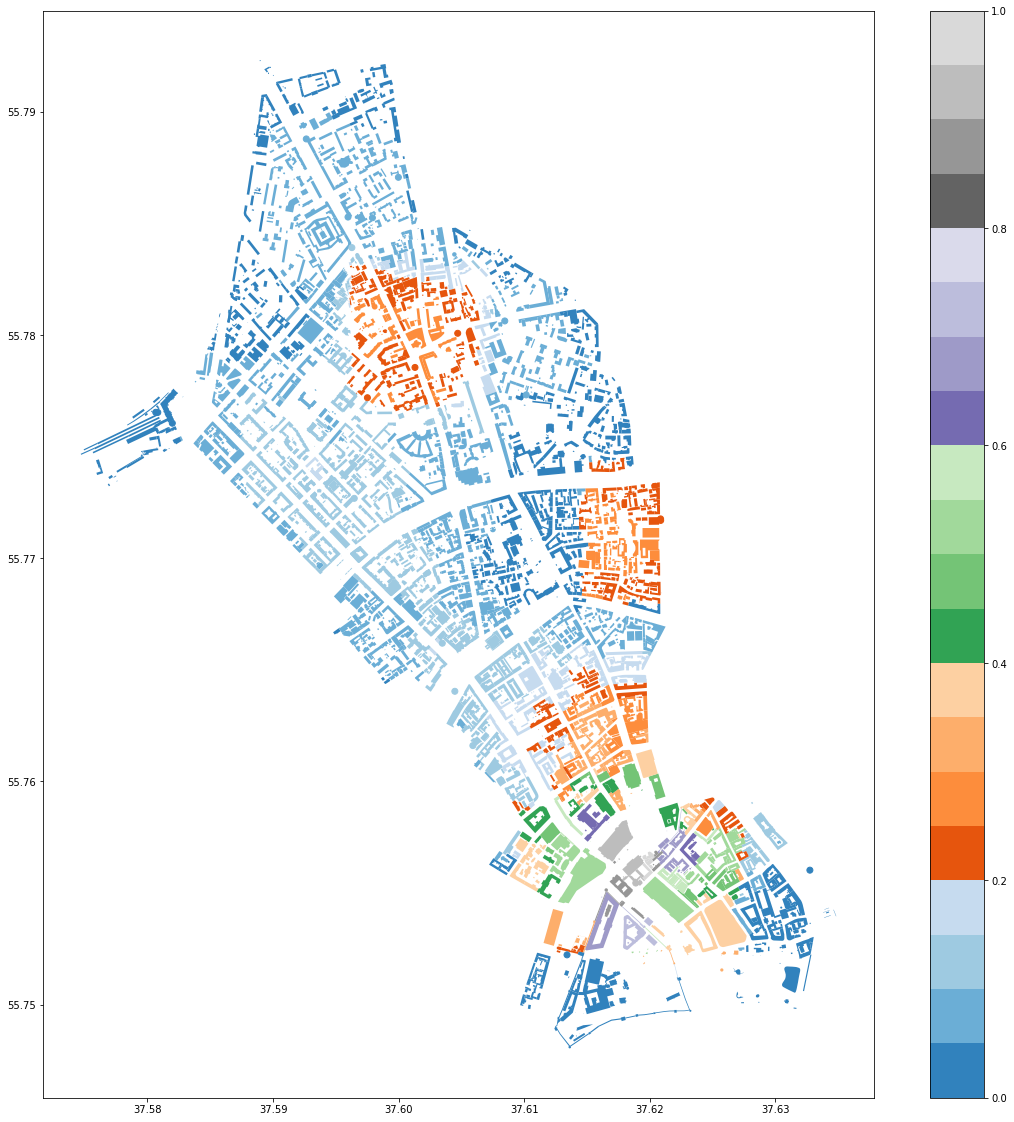

In [54]:
fig, axes = plt.subplots(1, 1, figsize=(20, 20))
infrastructure500.plot(column='quality', ax=axes, legend=True, cmap='tab20c')
plt.show()

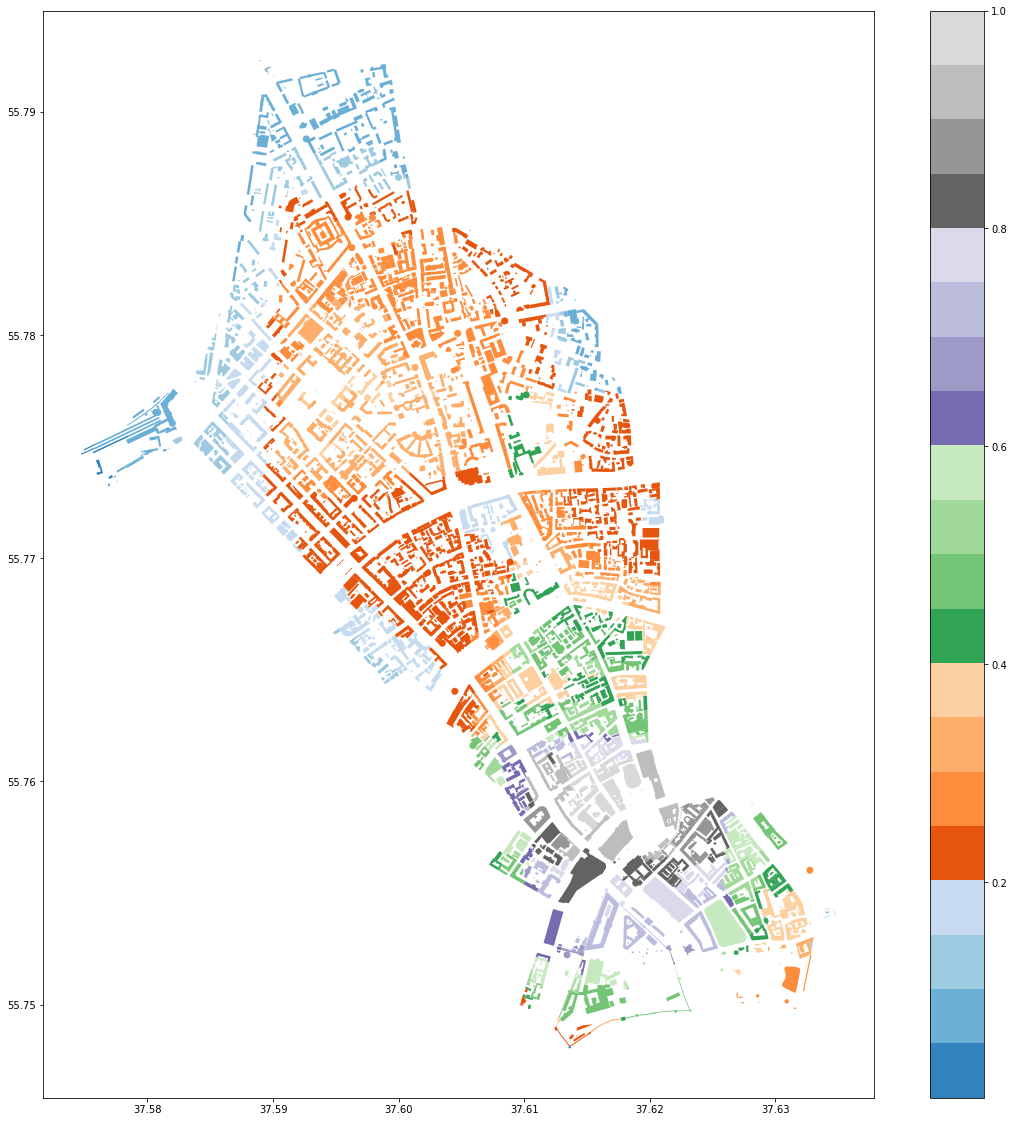

In [55]:
fig, axes = plt.subplots(1, 1, figsize=(20, 20))
infrastructure1000.plot(column='quality', ax=axes, legend=True, cmap='tab20c')
plt.show()